In [2]:
from __future__ import annotations

import random
from typing import Any

import numpy as np
from gym import Env
from gym.spaces import Box
from gym.spaces import Discrete
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

# Planning

## Task List
- ~~Drill multiple wells, one after the other and not to update the environment after every simulation.~~
- ~~Make sure well/wells dont crash into each other/itself or any faults/artifacts~~
- ~~Avoid 180 degree turns~~
- Have a target zone where the well eventually want to make it to and get higher reward
- Use a metric like MSE/UCS to get an estimate on the amount of energy required to drill and optimizing it to have lowest energy usage (also tie in the economic constraints)

## Action Space
- Surface Location ?? Pick it randomly or intentionally?
- Number of wells to drill
- Bit Movement
    -  Up
    -  Down
    -  Left
    -  Right
    -  Angle ?? If the grid size is as much as a stand then the max angle should be around 3 degrees 

## Observation Space

Same shape [matrix] as the input. Ideally 30 ft by 30 ft to match with the drilling pipe (90 ft by 90 ft for stand). Bool with true for wherever well is located.

## Possible Rewards
- While Drilling
    -  Proximity to Reservoir (based on the percentage of Normalized TOC?) - *Positive Reward*
    -  Proximity to Fault - *VERY HIGH Negative Reward*
    -  Proximity to itself or other wells - *VERY HIGH Negative Reward*
    -  Proximity to the possible depletion zone of an existing well - *VERY HIGH Negative Reward*
    -  Remaining oil in the zone of the well - *High Positive Reward*

- After Drilling
    -  Total UCS/MSE it was drilled through - *Negative Reward based on the UCS total, can also relate it to a USD amount*    
    -  Total Well Length - *Negative Reward based on the pipe count, can also relate it to a USD amount* 

# Simple Environment

In [ ]:
class SimpleDriller(Env):  # type: ignore
    """Simple driller environment."""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        self.model = np.loadtxt(
            env_config["model_path"],
            delimiter=env_config["delim"],
        )

        self.nrow, self.ncol = self.model.shape
        self.available_pipe = env_config["available_pipe"]

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []

        self.action_space = Discrete(4)

        self.observation_space = Box(
            low=0, high=1, shape=(self.nrow, self.ncol), dtype="bool"
        )
        self.reset()

    def step(  # noqa: C901
        self, action: int
    ) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            reward = 0

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info

    def update_state(self) -> None:
        """Update state method."""
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")

    def reset(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        self.surface_hole_location = [1, random.randint(0, self.ncol - 1)]  # noqa: S311
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.bit_location = self.surface_hole_location
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        return self.state


# Multidriller Environment

In [ ]:
class MultiDriller(Env):  # type: ignore
    """Simple driller environment for multiple wells"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         reward = 0
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -100
#             print('    Number of Rows exceeded')
#             reward = 0

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -100
#             print('    Number of Cols exceeded')
#             reward = 0

        else:
            self.reward = self.model[newrow, newcol] + self.pipe_used / 2
            if len(self.trajectory)>0:
                self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -100
#             print('    Crashed onto itself')
#             reward = 0
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -100
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
#                 done = True
                self.reward = -100  
#                 print('    Immediate 180 degree turn')
    
        info: dict[str, Any] = {}
        
        if done:
            self.wells_drilled += 1            
            self.multi_reward += self.reward 
            
            if len(self.trajectory)>0:
                self.multi_trajectory.append(self.trajectory)
                
            self.reset_well()
            
            if self.wells_drilled < self.num_wells:
                    done = False            
                    
            return self.state, self.multi_reward, done, info
        else:
            self.last_action = action
#             print(f'Last action: {actions[self.last_action]}')
            return self.state, self.reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 

        # Log the surface locations already used
        self.surface_location.append(self.surface_hole_location[1])
        
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


# Reward based on Proximity Environment

## Version 1

In [ ]:
class RewardDriller(Env):  # type: ignore
    """Driller environment for multiple wells with rewards based on proximity to reservoir"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])
        
        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -10
#             print('    Number of Rows exceeded')

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -10
#             print('    Number of Cols exceeded')

        else:
            if len(self.trajectory)>0:
                self.update_state()
            # Reward from the model
            self.reward = (self.model[newrow, newcol] * 2)
            
            # Checking if the reward from the model is negative and stopping the well
            if self.reward < 0:
                done = True
                self.reward = -10
#                 print('    Negative reward from model')
                
            else:                
                # Giving a small reward to encourage the agent to use pipes     
                self.reward += -self.pipe_used/10
                                
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

        # Avoid going along the surface
        if ((self.bit_location != self.surface_hole_location) &
                (self.bit_location[0] == 0)):
            self.reward = -10
            done = True
#             print('    Going along the surface horizontally')

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -10
#             print('    Crashed onto itself')
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -10
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
                self.reward = -10  
#                 done = True
#                 print('    Immediate 180 degree turn')

        if self.reward > 0:
            self.multi_reward += self.reward   
            
        info: dict[str, Any] = {}
        
        if done:
            self.wells_drilled += 1            
            done = False
            
            # Minimum pipe length for wells
            if len(self.trajectory) > 5:
                self.multi_trajectory.append(self.trajectory)
                
                # Cache the surface locations already used
                self.surface_location.append(self.surface_hole_location[1])
                self.reset_well()
                
                if len(self.multi_trajectory) < self.num_wells:
#                     print("MULTIREWARD")
                    return self.state, self.multi_reward, done, info  
                
            else:
                self.reset_well()
                self.reward = - 10            
            
            if len(self.multi_trajectory) == self.num_wells:
                done = True  
#                 print("MULTIREWARD")
                
                return self.state, self.multi_reward, done, info
            
            # Avoiding infinite loop
            elif self.wells_drilled > 100:
#                 print("INFINITE LOOP")
                done = True
                self.reward = -10
                
#             return self.state, self.reward, done, info
        
        else:
            self.last_action = action
        
#         print("REWARD")
            
        return self.state, self.reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


## Version 2

In [ ]:
class RewardDriller(Env):  # type: ignore
    """Driller environment for multiple wells with rewards based on proximity to reservoir"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])

        # Normalizing the model between o-10
        self.model = self.model*(100/self.model.max())

        self.model[np.less(self.model,0)] = -100
        self.model[self.model == 0] = 1

        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -100
#             print('    Number of Rows exceeded')

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -100
#             print('    Number of Cols exceeded')

        else:               
                
            # Incremental Reward from the model
#             self.reward = sum([self.model[x,y]*2 for x,y in self.trajectory[1:]])
            
            model_reward = (self.model[newrow, newcol])
            
            # Checking if the incremental reward from the model is negative and stopping the well
            if model_reward < 0:
                done = True
                self.reward = -100
#                 print('    Negative reward from model')
                
            else:
                # Giving a small -ve reward to encourage the agent to use less pipes     
                self.reward += (model_reward - self.pipe_used)
#                 print(f'Model Reward: {self.reward}')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#         # Avoid going along the surface
#         if ((self.bit_location != self.surface_hole_location) &
#                 (self.bit_location[0] == 0)):
#             self.reward += -100
#             done = True
# #             print('    Going along the surface horizontally')

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -100
#             print('    Crashed onto itself')
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -100
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
                self.reward = -100
                done = True
#                 print('    Immediate 180 degree turn')  
            
        info: dict[str, Any] = {}
#         print(done)
        if done:
            self.wells_drilled += 1  
#             print('Well Done')
            done = False
            
            # Minimum pipe length for wells
            if len(self.trajectory) > 5:
                self.multi_trajectory.append(self.trajectory)
                
                # Cache the surface locations already used
                self.surface_location.append(self.surface_hole_location[1])
                
                # Update state
                self.update_state()
                
                if self.reward > 0:
                    self.multi_reward += self.reward
                else:
                    self.multi_reward = -100
                
            else:
                self.multi_reward = -100   
                       
            if len(self.multi_trajectory) == self.num_wells:
                done = True  
#                 print("FINAL REWARD")
            
            # Avoiding infinite loop
            elif self.wells_drilled > 100:
#                 print("INFINITE LOOP")
                done = True
                self.multi_reward = -100                
            
            self.reset_well()
            
        else:
            self.last_action = action
            self.multi_reward += self.reward
            
#         print(self.reward)
             
        return self.state, self.multi_reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


## Version 3

In [ ]:
class RewardDriller(Env):  # type: ignore
    """Driller environment for multiple wells with rewards based on proximity to reservoir"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        
        self.model = np.loadtxt(env_config["model_path"],
                                delimiter=env_config["delim"])

        # Normalizing the model between o-10
        self.model = self.model*(100/self.model.max())

        self.model[np.less(self.model,0)] = -100
        self.model[self.model == 0] = 1

        self.nrow, self.ncol = self.model.shape
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        
        self.available_pipe = env_config["available_pipe"]
            
        self.num_wells = env_config["num_wells"]
                
        
        self.wells_drilled = 0 
        self.reward = 0
        self.multi_reward = 0

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []
        self.surface_location = []
        self.last_action = None
            
            
        self.multi_trajectory: list[list[list[int]]] = []
        self.action_space = Discrete(4)        

        self.observation_space = Box(low=0, high=1, 
                                     shape=(self.nrow, self.ncol), 
                                     dtype="bool")
        self.reset_well()
        self.reset()
    
# ----------------------------------------------------------------------------------------------------------------      

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        
        done = False
#         self.reset_well()
        
        actions = {
                   0: [1, 0],  # down
                   1: [0, -1],  # left
                   2: [0, 1],  # right
                   3: [-1, 0],  # up
                  }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            self.reward = -100
#             print('    Number of Rows exceeded')

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            self.reward = -100
#             print('    Number of Cols exceeded')

        else:               
                
            # Incremental Reward from the model
#             self.reward = sum([self.model[x,y]*2 for x,y in self.trajectory[1:]])
            
            model_reward = (self.model[newrow, newcol])
            
            # Checking if the incremental reward from the model is negative and stopping the well
            if model_reward < 0:
                done = True
                self.reward = -100
#                 print('    Negative reward from model')
                
            else:
                # Giving a small -ve reward to encourage the agent to use less pipes     
                self.reward += (model_reward - self.pipe_used)
#                 print(f'Model Reward: {self.reward}')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#         # Avoid going along the surface
#         if ((self.bit_location != self.surface_hole_location) &
#                 (self.bit_location[0] == 0)):
#             self.reward += -100
#             done = True
# #             print('    Going along the surface horizontally')

        if self.pipe_used == self.available_pipe:
            done = True
            self.reward = 0
#             print('    Done with total pipes')

        if self.bit_location in self.trajectory[:-1]:
            done = True
            self.reward = -100
#             print('    Crashed onto itself')
            
        if self.bit_location in [item for sublist in self.multi_trajectory for item in sublist]:
            done = True
            self.reward = -100
#             print('    Crashed into a different well')
        
        # Avoid immediate 180 degree turns
        if (self.last_action != None):
            if (np.add(actions[action], actions[self.last_action]).tolist() == [0,0]):
                self.reward = -100
                done = True
#                 print('    Immediate 180 degree turn')  
            
        info: dict[str, Any] = {}
#         print(done)
        if done:
            self.wells_drilled += 1  
#             print('Well Done')
            done = False
            
            # Minimum pipe length for wells
            if len(self.trajectory) > 5:
                self.multi_trajectory.append(self.trajectory)
                
                # Cache the surface locations already used
                self.surface_location.append(self.surface_hole_location[1])
                
                # Update state
                self.update_state()
                
                if self.reward > 0:
                    self.multi_reward += self.reward
                else:
                    self.multi_reward = -100
                
            else:
                self.multi_reward = -100   
                       
            if len(self.multi_trajectory) == self.num_wells:
                done = True  
#                 print("FINAL REWARD")
            
            # Avoiding infinite loop
            elif self.wells_drilled > 100:
#                 print("INFINITE LOOP")
                done = True
                self.multi_reward = -100                
            
            self.reset_well()
            
        else:
            self.last_action = action
            self.multi_reward += self.reward
            
#         print(self.reward)
             
        return self.state, self.multi_reward, done, info

# ----------------------------------------------------------------------------------------------------------------      

    def update_state(self) -> None:
        """Update state method."""        
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1
            
# ----------------------------------------------------------------------------------------------------------------      

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")
        
# ----------------------------------------------------------------------------------------------------------------      

    def reset_well(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        
        # random surface location  that was not used before
        self.surface_hole_location = [0, random.choice(list(set(range(0, self.ncol - 1))-set(self.surface_location)))] 
        self.bit_location = self.surface_hole_location            
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        self.reward = 0
        
        return self.state

# ----------------------------------------------------------------------------------------------------------------      
    
    def reset(self) -> NDArray[np.bool_]:
        
        """Reset the status of the environment."""
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.multi_trajectory = []
        self.surface_location = []
        self.multi_reward = 0 
        self.wells_drilled = 0 
        return self.state


# Horizontal well Driller

In [ ]:
# Horizontal well driller with a specific start point

from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD , Adam, RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")

model = np.loadtxt(env_config["model_path"],
                   delimiter=env_config["delim"])

model[np.less(model,0)] = -10

In [ ]:
visited_mark = 0.8  # Cells visited by the bit will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [ ]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [ ]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [ ]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

In [ ]:
qmaze = Qmaze(model)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

In [ ]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [ ]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [ ]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [ ]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [ ]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [ ]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
qmaze = Qmaze(maze)
show(qmaze)

In [ ]:
model = build_model(maze)

In [ ]:
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

In [ ]:
model

# Simple  Q learning

In [22]:
class QDriller:  # type: ignore
    """Driller environment for horizontal wells with self.rewards based on Q learning"""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""

        self.rewards = np.loadtxt(env_config["model_path"],
                                  delimiter=env_config["delim"])
        
        self.available_pipe = env_config["available_pipe"]

        # Normalizing the model
        self.rewards = self.rewards * (100 / self.rewards.max())

        self.rewards[np.less(self.rewards, 0)] = -100
        self.rewards[self.rewards == 0] = -1

        self.actions = ['up', 'right', 'down', 'left']

        self.q_values = np.zeros((self.rewards.shape[0],
                                  self.rewards.shape[1],
                                  len(self.actions)))

        self.trajectory = []        
        self.end = 0
        
        self.action_cache = np.nan 
        
        self.explored = np.zeros((self.rewards.shape[0],
                                  self.rewards.shape[1]))
        
#----------------------------------------------------------------------------------------------------------------

    # define a function that determines if the specified location is a terminal state
    def is_terminal_state(self, current_row_index, current_column_index):
        if ((len(self.trajectory) > 1) &
                (self.rewards[current_row_index, current_column_index] == -100)):
            self.end = 1
            return True
        else:
            return False
        
#----------------------------------------------------------------------------------------------------------------
        
    # define a function that will choose a random, non-terminal starting location
    def get_starting_location(self):
        # get a random column index
        current_row_index = np.random.randint(self.rewards.shape[0])
        current_column_index = np.random.randint(self.rewards.shape[1])
        return current_row_index, current_column_index
#         return 18, 18

#     def get_unique_starting_location(self):
#         # get a random column index
#         current_row_index = np.random.randint(self.rewards.shape[0])
#         current_column_index = np.random.randint(self.rewards.shape[1])
#         return current_row_index, current_column_index
# #         return 18, 0
    
    
#----------------------------------------------------------------------------------------------------------------

    #numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
    # define a function that will decide the valid actions to avoid crashing into itself
    def get_valid_actions(self, current_row_index, current_column_index):
        va = [0, 1, 2, 3]
        try:
            # Avoid turning back into itself
            if [current_row_index - 1, current_column_index] in self.trajectory:
                va.remove(0)
            if [current_row_index, current_column_index + 1] in self.trajectory:
                va.remove(1)
            if [current_row_index + 1, current_column_index] in self.trajectory:
                va.remove(2)
            if [current_row_index, current_column_index - 1] in self.trajectory:
                va.remove(3)

            # Remove left move if it is the first column
            if current_column_index == 0:
                va.remove(3)

#             # Remove up move if it is the first row
#             if current_row_index == 0:
#                 va.remove(0)
                
            # Force to move down when at surface
            if current_row_index == 0:
                return [2]


            # Remove right move if it is the last column
            if current_column_index == (self.rewards.shape[1]-1):
                va.remove(1)

            # Remove down move if it is the last row
            if current_row_index == (self.rewards.shape[0]-1):
                va.remove(2)
                
            # Avoid going up if is gonna hit the surface
            if (current_row_index - 1) == 0:
                va.remove(0)
            
#             # Avoid wellbore looping
#             if self.action_cache.notna():
#                 va.remove(self.action_cache)

        except:
#             self.end = 1
            pass
            
        return va
    
#----------------------------------------------------------------------------------------------------------------

    # define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
    def get_next_action(self, current_row_index, current_column_index, epsilon):
        
        valid_actions = self.get_valid_actions(current_row_index, current_column_index)
        
        if len(valid_actions) == 0:
            self.end = 1
            
        if (len(valid_actions) != 0) & (np.random.random() < epsilon):
            action = max(valid_actions,key = lambda i: self.q_values[current_row_index, current_column_index].tolist()[i])
#             print(f'Valid Actions: {valid_actions}, Picked Action: {action}')
            return action
        else:
            return np.random.randint(len(self.actions))
        
#----------------------------------------------------------------------------------------------------------------

    def get_next_action_train(self, current_row_index, current_column_index, epsilon):
        if np.random.random() < epsilon:
            return np.argmax(self.q_values[current_row_index, current_column_index])
        else:
            return np.random.randint(len(self.actions))
        
#----------------------------------------------------------------------------------------------------------------

    # define a function that will get the next location based on the chosen action
    def get_next_location(self, current_row_index, current_column_index, action_index):

        new_row_index = current_row_index
        new_column_index = current_column_index
        
        if self.actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1

        elif self.actions[action_index] == 'right' and current_column_index < self.rewards.shape[1] - 1:
            new_column_index += 1

        elif self.actions[action_index] == 'down' and current_row_index < self.rewards.shape[0] - 1:
            new_row_index += 1

        elif self.actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        else:
            self.end = 1

        return new_row_index, new_column_index

#----------------------------------------------------------------------------------------------------------------

    # Define a function to train and populate the q table
    def populate_q_table(self, num_episodes, epsilon = 0.1, discount_factor = 0.9, learning_rate = 0.9):
        print('Training Started!')
        for episode in range(num_episodes):
            self.reset()

            # get the starting location for this episode
            row_index, column_index = self.get_starting_location()
#             print(row_index, column_index)

            self.trajectory.append([row_index, column_index])
#             print(self.trajectory)
            
#             print(self.rewards[row_index, column_index])
            
#             print(self.is_terminal_state(row_index, column_index))

            # continue taking actions (i.e., moving) until we reach a terminal state
            while not (self.is_terminal_state(row_index, column_index) | (self.end == 1)):

                # choose which action to take (i.e., where to move next)
                action_index = self.get_next_action(row_index, column_index, epsilon)

                # perform the chosen action, and transition to the next state (i.e., move to the next location)
                old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
                row_index, column_index = self.get_next_location(row_index, column_index, action_index)

                # receive the reward for moving to the new state
#                 if ([row_index, column_index] in self.trajectory):
#                     reward = -100
#                 elif (row_index == 0):
#                     reward = -100
#                 else:
#                     reward = self.rewards[row_index, column_index] - len(self.trajectory)
#                 #         print(reward)

                if [row_index, column_index] in self.trajectory:
                    self.end == 1
                    reward += -100
                    break
                else:
                    self.trajectory.append([row_index, column_index])
                    # From Model
                    reward = self.rewards[row_index, column_index]*5

                    # To encourage to maintain the shortest path
                    reward += -len(self.trajectory)

                    # To ensure that a horizontal well is drilled
                    reward += abs(self.trajectory[-1][1] - self.trajectory[0][1])
#                     print(reward)

#                     # To make sure target pipes are used
#                     reward += (self.available_pipe -len(self.trajectory))*2
                    
                    # Adding a -ve reward to encourage the agent to visit unique rows,columns
                    rows = [i[0] for i in self.trajectory]
                    columns = [i[1] for i in self.trajectory]

                    reward += -(len(rows) - len(set(rows)))*1
                    reward += -(len(columns) - len(set(columns)))*20
                    
#                     # Add a -ve reward to identify simultaneous right/left turns in the to avoid wellbore tornado effect
#                     if (action_index == self.action_cache):
#                         reward += -100
                    
                if (action_index == 1) | (action_index == 3):
                    self.action_cache = action_index                    

                old_q_value = self.q_values[old_row_index, old_column_index, action_index]

                temporal_difference = reward + (
                            discount_factor * np.max(self.q_values[row_index, column_index])) - old_q_value

                # update the Q-value for the previous state and action pair
                new_q_value = old_q_value + (learning_rate * temporal_difference)
#                 print(new_q_value)

                self.q_values[old_row_index, old_column_index, action_index] = new_q_value
                self.explored[old_row_index, old_column_index] = 1
    
    
            if (episode != 0) & ((episode + 1) % 100_000 == 0):
                print(f'    {"{:,}".format(episode + 1)} episodes completed')

#             print(self.trajectory)
        
        print('Training Complete!')
        
#----------------------------------------------------------------------------------------------------------------

    # Define a function that will get the shortest path
    def get_shortest_path(self, start_row_index, start_column_index):
        self.reset()
        current_row_index, current_column_index = start_row_index, start_column_index
        self.trajectory.append([current_row_index, current_column_index])

        pipes_used = 0
#         print(self.is_terminal_state(current_row_index, current_column_index))
        
        while not (self.is_terminal_state(current_row_index, current_column_index) | (self.end == 1)):
#             print(self.trajectory)
            # get the best action to take
            action_index = self.get_next_action(current_row_index, current_column_index, 1.)
#             print(current_row_index, current_column_index)
#             print(self.actions[action_index])
            # move to the next location on the path, and add the new location to the list
            current_row_index, current_column_index = self.get_next_location(current_row_index, current_column_index,
                                                                        action_index)
#             print(f'{current_row_index}, {current_column_index}\n')

            
            pipes_used += 1

            if (pipes_used == self.available_pipe):
                self.end = 1
                print('Pipes Over')
                
            if ([current_row_index, current_column_index] in self.trajectory):
                self.end = 1
                print(f'Index in trajectory - [{current_row_index},{current_column_index}]')
                
            else:
                self.trajectory.append([current_row_index, current_column_index])
#                 print(self.trajectory)

        return self.trajectory

#----------------------------------------------------------------------------------------------------------------

    # Define a function that will reset everything
    def reset(self):
        self.trajectory = []        
        self.end = 0
        self.action_cache = []

In [23]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=100, num_wells = 1, delim=",")
env = QDriller(env_config)

#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left

In [24]:
env.populate_q_table(500_000)

# plt.figure(figsize=(15, 7))
# plt.imshow(env.explored, vmin=0, vmax=1)

Training Started!
    100,000 episodes completed
    200,000 episodes completed
    300,000 episodes completed
    400,000 episodes completed
    500,000 episodes completed
Training Complete!


Pipes Over


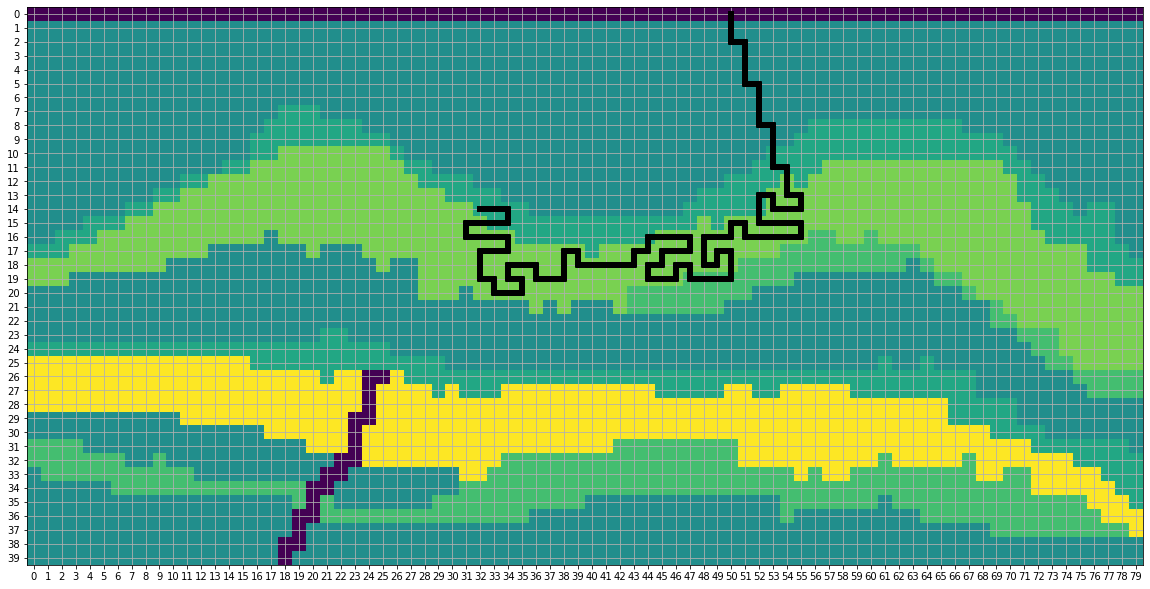

In [28]:
start_row = 0
start_column = 50

#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left

trajectory = env.get_shortest_path(start_row, start_column)

plt.figure(figsize=(20, 20))
plt.imshow(env.rewards, vmin=-100, vmax=100)

for i in range(0,len(trajectory)):
    traj_z, traj_x = np.asarray(trajectory).T
    plt.plot(traj_x, traj_z, "-", linewidth=6, color = 'k')

plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

# Test Environment

In [ ]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")

env = RewardDriller(env_config)

episodes = 1

actions = {
           0: [1, 0],  # down
           1: [0, -1],  # left
           2: [0, 1],  # right
           3: [-1, 0],  # up
          }
plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for episode in range(1,episodes+1):
    
    state = env.reset()
    done = False
    reward = 0
    
    print("Beginning Drill Campaign:", episode)
    
    while not done:
        action = env.action_space.sample()
#         print(f"    Action: {actions[action]}")
        
        state, reward, done, info = env.step(action)
#         print(f"    Total Reward: {reward}")
#         print(f"    done: {done}\n")

    for i in range(0,len(env.multi_trajectory)):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

# Train the Agent

## PPO

In [ ]:
from stable_baselines3 import PPO

# More the number of wells, more time to train 
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
env = RewardDriller(env_config)
# env = MultiDriller(env_config)


ppo = PPO("MlpPolicy", env, verbose=1)
ppo.learn(total_timesteps = 800_000, log_interval=10)

In [ ]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
# env = MultiDriller(env_config)
env = RewardDriller(env_config)

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 100
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = ppo.predict(state)
        state, reward, done, info = env.step(action)
#         print(f"    Reward: {reward}")

    for i in range(0,len(env.multi_trajectory)):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

In [ ]:
plt.imshow(env.state)

## DQN

In [ ]:
from stable_baselines3 import DQN

# env = RewardDriller(env_config)

dqn = DQN("MlpPolicy", env, verbose=1)
dqn.learn(total_timesteps=500_000, log_interval=1_000)


In [ ]:
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=70, num_wells = 3, delim=",")
# env = RewardDriller(env_config)

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

episodes = 100
for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = dqn.predict(state, deterministic=True)
        state, reward, done, info = env.step(action)
#     print(f"    Reward: {reward}")

    for i in range(0,len(env.multi_trajectory)):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()

## A2C

In [ ]:
from stable_baselines3 import A2C

# More the number of wells, more time to train 
# env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=100, num_wells = 3, delim=",")

# env = RewardDriller(env_config)

a2c = A2C("MlpPolicy", env, verbose=3)
a2c.learn(total_timesteps=500_000, log_interval=1000)

In [ ]:
env = RewardDriller(env_config)

episodes = 100

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)

for episode in range(1, episodes + 1):
#     print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
#     reward = 0

    while not done:
        action, _states = a2c.predict(state)
        state, reward, done, info = env.step(action)
#     print(f"    Reward: {reward}")

    for i in range(0,len(env.multi_trajectory)):
        traj_z, traj_x = np.asarray(env.multi_trajectory[i]).T
        plt.plot(traj_x, traj_z, "-", linewidth=6)

    plt.xticks(np.arange(0, 80, 1.0))
    plt.yticks(np.arange(0, 40, 1.0))
    plt.xlim([-0.5, 79.5])
    plt.ylim([39.5, -0.5])
    plt.grid()